## Modeling Atmospheric Turbulence in Orbital Angular Momentum of Light (OAM)

In [1]:
import numpy as np 
import math
from scipy.integrate import quad
import sympy as sp
import matplotlib.pyplot as plt

In [2]:
# Optical parameters
labda = 1550*10**(-9) # Optical wavelength
k = 2*math.pi/labda # Optical wavenumber
w0 = 15*10**(-2) # Beamwaist radius
rt = 33*10**(-2) # Transmitter aperture radius
ra = 3.7 # Receiver aperture radius
zR = math.pi*(w0**2)/labda # Rayleigh range
p = 0 # Radial mode number
Lp = 1 # Generalized Laguerre polynomial of order zero
la = np.array([0, 1, 2, 3, 4]) # OAM quantum number
lra = la

In [3]:
# Atmospheric channel parameters
urms = 6 # RMS wind speed
A = 9.6*10**(-14) # Hufnagel-Valley model at h=0 altitude

In [4]:
# System parameters
h0a = np.array([0, 1000, 3000]) # Ground station altitude
Ha = np.arange(150, 501, 50)*10**3 # Satellite altitude
thetaz = 0 # Zenith angle
sims = 2 # Number of realizations of the random variables

In [57]:
# Coordinate systems construction

# Calculate the radial coordinate
dr = 0.025
r = np.arange(0, ra+0.1*dr, dr)
print(r.shape)

# Calculate the azimuthal coordinate
dtheta = 2*math.pi/r.size
theta = np.arange(0, 2*math.pi, dtheta)
print(theta.shape)

# Calculate the corresponding cartesian coordinates
x = r*np.cos(theta)
y= r*np.sin(theta)

# Create meshgrid out of the polar coordinates
rm, thetam, thetama = np.meshgrid(r, theta, theta) 


(149,)
(149,)


In [6]:
def oam_atm_turbulence(H, k, w0, A, urms, thetaz, h0, l, zR, sims):
    # Calculate the channel distance
    L = (H-h0)/math.cos(thetaz)

    # Calculate the realizations of the random variables
    Omega = k*(w0**2)/2/L

    def Cn2 (h, urms, A):
        return 0.00594*((urms/27)**2)*((h*10**(-5))**10)*math.exp(-h/1000)+(2.7*10**(-16))*math.exp(-h/1500)+A*math.exp(-h/100)

    def fun(h, urms, A, h0):
        return Cn2(h, urms, A)*(h-h0)**(5/6)
    
    # Calculate the Rytov variance
    temp = quad(fun, h0, H, args=(urms, A, h0))
    sigmaR2 = 2.25*(k**(7/6))*(sp.sec(thetaz)**(11/6))*temp[0]

    # Calculate the scintillation index
    sigmaI2 = math.exp((0.49*sigmaR2/((1+1.11*sigmaR2**(12/5))**(7/6)))+(0.51*sigmaR2/((1+0.69*sigmaR2**(12/5))**(5/6))))-1

    meanTheta = np.log(((1+2.96*sigmaI2*Omega**(5/6))**2)/((Omega**2)*math.sqrt((1+2.96*sigmaI2*Omega**(5/6))**2+1.2*sigmaI2*Omega**(5/6))))
    varTheta = np.log(1+(1.2*sigmaI2*Omega**(5/6))/((1+2.96*sigmaI2*Omega**(5/6))**2))
    corTheta = np.log(1-(0.8*sigmaI2*Omega**(5/6))/((1+2.96*sigmaI2*Omega**(5/6))**2))
    varc0 = 0.33*(w0**2)*sigmaI2*Omega**(-7/6)
    M = np.array([[varc0, 0, 0, 0], [0, varc0, 0, 0], [0, 0, varTheta, corTheta], [0, 0, corTheta, varTheta]])
    mean = np.array([0, 0, meanTheta, meanTheta])
    B = np.random.default_rng().multivariate_normal(mean, M, sims)

    x0 = B[:, 0]
    y0 = B[:, 1]
    Theta1 = B[:, 2]
    Theta2 = B[:, 3]
    W1 = np.sqrt(np.exp(Theta1)*w0**2)*math.sqrt(abs(l)+1)
    W2 = np.sqrt(np.exp(Theta2)*w0**2)*math.sqrt(abs(l)+1)
    phi = np.random.default_rng().uniform(0, math.pi/2, sims)

    # Calculate the Fried parameter
    temp = quad(Cn2, h0, H, args=(urms, A))
    rF = (0.423*(k**2)*sp.sec(thetaz)*temp[0])**(-3/5)
    rF= np.array(rF).astype(np.float64) # Convert rF to numpy 

    return x0, y0, W1, W2, phi, rF;

In [58]:
avPl = np.zeros([h0a.size*la.size, Ha.size])

# Calculate the symmetrical circular aperture function
Hr = np.heaviside(ra-r, 0.5)

for u in range(0, h0a.size):
    h0 = h0a[u]
    for m in range(0, la.size):
        l = la[m]
        lr = lra[m]
        for j in range(0, Ha.size):
            H = Ha[j]

            # Calculate the channel distance
            L = (H-h0)/math.cos(thetaz)
            
            # Define the longitudinal plane (receiver)
            z = L
            w = w0*math.sqrt(1+(z/zR)**2)
            
            # Calculate the RMS beam radius
            r0lrms = math.sqrt((abs(l)+1)/2)*w
            
            # Calculate the quantity within most (~90%) of the optical power is
            # distributed
            r0l = math.sqrt(2)*r0lrms

            # Calculate the realizations of the random variables
            x0, y0, W1, W2, phi, rF = oam_atm_turbulence(H, k, w0, A, urms, thetaz, h0, l, zR, sims)

            # Calculate the ensemble average of the phase profile
            Ca = np.exp(-6.88*(2**(2/3))*((rm/rF)**(5/3))*np.absolute(np.sin((thetam-thetama)/2))**(5/3))

            # Calculate the OAM detection probability
            Pl = np.zeros(sims)
            for i in range(0, sims):
                # Change centroid position of the beam
                xt = x-x0[i]
                yt = y-y0[i]

                # Calculate the beam shape matrix
                S = np.array([[W1[i]*math.cos(phi[i]), -W2[i]*math.sin(phi[i])], [W1[i]*math.sin(phi[i]), W2[i]*math.cos(phi[i])]])/r0l

                # Distort the beam
                ci = np.matmul(np.linalg.inv(S), np.concatenate([[xt], [yt]]))
                xi = ci[0, :]
                yi = ci[1, :]

                # Calculate the perturbed polar coordinates
                ri = np.sqrt(xi**2+yi**2)
                thetai = np.arctan2(yi ,xi)

                # Create meshgrid out of the perturbed polar coordinates
                rim, thetaim, thetaima = np.meshgrid(ri, thetai, thetai)

                # Calclulate the perturbed radial profile
                Ri = 2*math.sqrt(math.factorial(p)/math.factorial(p+abs(l)))*(1/w)*((ri*math.sqrt(2)/w)**abs(l))*np.exp(-ri**2/w**2)*Lp*np.exp(1j*k*ri**2*z/(2*(z**2+zR**2)))*np.exp(-1j*(2*p+abs(l)+1)*np.arctan(z/zR))

                # Calculate the detection propability
                Thetar1 = np.sum(Ca*np.exp(-1j*l*thetaima)*np.exp(1j*lr*thetama), axis=2)*dtheta
                Thetar2 = np.sum(Thetar1*np.exp(1j*l*thetaim[:, :, 0])*np.exp(-1j*lr*thetam[:, :, 0]), axis=0)*dtheta
                Pl[i] = sum(((abs(Ri)*abs(Hr))**2)*(Thetar2*r))*dr/np.linalg.det(S)/4/(math.pi**2)

            avPl[m+u*la.size, j] = sum(Pl)/sims     

(0.001, 1)

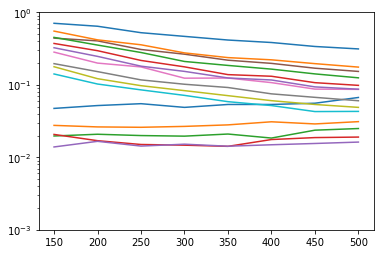

In [59]:
# Plot the results
fig, ax = plt.subplots()
plt.plot(Ha*10**(-3), avPl[0,:], Ha*10**(-3), avPl[1,:], Ha*10**(-3), avPl[2,:], Ha*10**(-3), avPl[3,:], Ha*10**(-3), avPl[4,:], Ha*10**(-3), avPl[5,:], Ha*10**(-3), avPl[6,:], Ha*10**(-3), avPl[7,:], Ha*10**(-3), avPl[8,:], Ha*10**(-3), avPl[9,:], Ha*10**(-3), avPl[10,:], Ha*10**(-3), avPl[11,:], Ha*10**(-3), avPl[12,:], Ha*10**(-3), avPl[13,:], Ha*10**(-3), avPl[14,:])
plt.yscale('log')
ax.set_ylim(10**(-3), 1)